# Importance weighted autoencoders
Code based on [???]

Modified by Bence Halpern for dissemination purposes at NKI Deep Learning Journal Club

In [2]:
import tensorflow.examples.tutorials.mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
import keras.optimizers as optimizers
from keras.models import load_model
import pickle

import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras import losses
import sys

Using TensorFlow backend.


**Parameters**

Standard MNIST parameters, n_z is taken two so it is easier to visualise separation in the latent space

In [63]:
m = 20
n_z = 2
epochs = 100
image_dim = 28
input_shape = image_dim * image_dim
hidden_size = 200
k = 2
log2pi = K.log(2 * np.pi)

**Dataset**

Just a minor reminder: we are going to use the standard MNIST to evaluate or IWAE

![MNIST](MNIST.png)

In [53]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [65]:
inputs = Input(shape=(input_shape,), name='encoder_input')
encoder_layer_1 = Dense(hidden_size, activation='relu')(inputs)
encoder_layer_2 = Dense(hidden_size, activation='relu')(encoder_layer_1)
mu = Dense(n_z, activation='linear')(encoder_layer_2)
sigma = Dense(n_z, activation='softplus')(encoder_layer_2)

def sample_z(args):
    local_mu, local_sigma= args
    local_mu = K.repeat(local_mu, k)
    local_sigma = K.repeat(local_sigma, k)
    eps = K.random_normal(shape=(K.shape(local_mu)[0], k, K.shape(local_mu)[2]), mean=0., stddev=1.)
    return local_mu + local_sigma * eps

z = Lambda(sample_z, output_shape=(k, n_z,), name='z')([mu, sigma])
decoder_layer_1 = Dense(hidden_size, activation='relu')
decoder_layer_2 = Dense(hidden_size, activation='relu')
decoder_out = Dense(input_shape, activation='sigmoid')


# Autoencoder Model object 
vae_outputs = decoder_out(decoder_layer_2(decoder_layer_1(z)))
vae = Model(inputs, vae_outputs)

# Encoder model object: p(z|x)
encoder = Model(inputs, [mu, sigma, z], name='encoder')

# Decoder model object: p(x|z)
generator_input = Input(shape=(n_z,), name='z_sampling')
generator_output = decoder_out(decoder_layer_2(decoder_layer_1(generator_input)))
decoder = Model(generator_input, generator_output, name='decoder')

In [66]:


def iwae_loss(y_true, y_pred):
    local_mu = K.repeat(mu, k)
    local_sigma = K.repeat(sigma, k)
    
    kl = -(1/2) * (K.sum(K.square(local_sigma) + K.square(local_mu) - K.log(K.square(1e-8 + local_sigma)) - 1,axis=-1))

    # Negative log likelihood -> cross entropy for classification
    log_bernoulli = K.sum(y_true * K.log(y_pred + 1e-8) + (1 - y_true) * K.log(1 - y_pred + 1e-8), axis=-1)

    #log_weights = log_bernoulli + kl
    log_weights = log_bernoulli + kl
    
    # Importance weights need to be normalised and softmax exactly does this
    importance_weight = K.softmax(log_weights, axis=1)
    return -K.sum(importance_weight * log_weights, axis=-1)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-4)
vae.compile(optimizer=adam, loss=iwae_loss)

history2 = vae.fit(x_train, np.rollaxis(np.tile(x_train, reps=(k, 1, 1)), axis=1), shuffle=True, batch_size=m, epochs=epochs, validation_data=(x_test, np.rollaxis(np.tile(x_test, reps=(k, 1, 1)), axis=1)))



Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 63s 1ms/step - loss: 172.5465 - val_loss: 160.3620
Epoch 2/100
60000/60000 [==============================] - 94s 2ms/step - loss: 155.4595 - val_loss: 152.2304
Epoch 3/100
60000/60000 [==============================] - 94s 2ms/step - loss: 150.3934 - val_loss: 149.4149
Epoch 4/100
60000/60000 [==============================] - 94s 2ms/step - loss: 147.6535 - val_loss: 146.6463
Epoch 5/100
60000/60000 [==============================] - 100s 2ms/step - loss: 146.2555 - val_loss: 146.5285
Epoch 6/100
60000/60000 [==============================] - 105s 2ms/step - loss: 145.2482 - val_loss: 144.8406
Epoch 7/100
60000/60000 [==============================] - 107s 2ms/step - loss: 144.4069 - val_loss: 144.5933
Epoch 8/100
60000/60000 [==============================] - 113s 2ms/step - loss: 143.8302 - val_loss: 143.7974
Epoch 9/100
60000/60000 [==============================] - 98s 2ms

Epoch 74/100
60000/60000 [==============================] - 21s 343us/step - loss: 137.3983 - val_loss: 139.3172
Epoch 75/100
60000/60000 [==============================] - 21s 345us/step - loss: 137.8762 - val_loss: 138.9472
Epoch 76/100
60000/60000 [==============================] - 20s 338us/step - loss: 137.8916 - val_loss: 138.3726
Epoch 77/100
60000/60000 [==============================] - 21s 346us/step - loss: 137.5443 - val_loss: 139.0815
Epoch 78/100
60000/60000 [==============================] - 21s 347us/step - loss: 137.5211 - val_loss: 138.3633
Epoch 79/100
60000/60000 [==============================] - 20s 335us/step - loss: 137.7031 - val_loss: 138.4978
Epoch 80/100
60000/60000 [==============================] - 21s 346us/step - loss: 137.1055 - val_loss: 138.4045
Epoch 81/100
60000/60000 [==============================] - 21s 343us/step - loss: 137.0704 - val_loss: 138.7210
Epoch 82/100
60000/60000 [==============================] - 20s 341us/step - loss: 137.1118 - va

## Latent space visualisation

(10000, 784)
7
(10000, 5, 2)
(10000, 2)


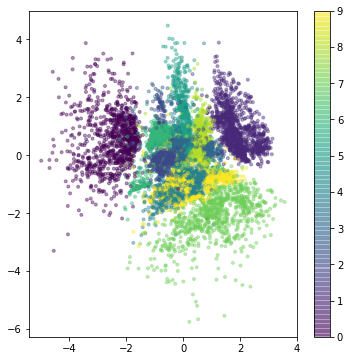

In [56]:
# display a 2D plot of the digit classes in the latent space
mu,sigma,z_test = encoder.predict(x_test, batch_size=m)
plt.figure(figsize=(6, 6))

print(x_test.shape)
print(y_test[0])
print(z_test.shape)
print(mu.shape)
plt.scatter(mu[:,0], mu[:,1], c=y_test,alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()


## Loss function

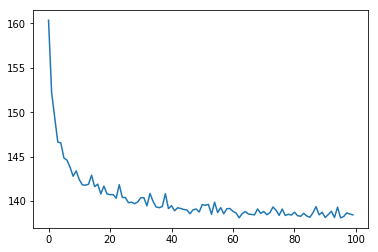

In [67]:
plt.plot(history2.history['val_loss'])